In [1]:
import pandas as pd
from top2vec import Top2Vec
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.data_wrangling.load_data import load_political_quotes

# Load quotations from politicians from France, Italy, Germany, Spain and Poland

First, we load the quotes from politicians from France, Italy, Germany, Spain and Poland.

We selected these countries as they are quite similar, all of them are in the European Union and, in addition, they have a similar number of quotes.

In [17]:

quotes = []
countries = ['France', 'Italy', 'Germany', 'Spain', 'Poland']
for batch in load_political_quotes(country=countries, chunksize=20000):
    quotes.append(batch)

In [18]:
politician_quotes = pd.concat(quotes, axis=0, ignore_index=True)
politician_quotes = politician_quotes[['quotation', 'speaker', 'country', 'political_alignment', 'date', 'political_party']]
politician_quotes['date'] = pd.to_datetime(politician_quotes['date'])
politician_quotes


,quotation,speaker,country,political_alignment,date,political_party
0,"A big, fast, athletic guy that just doesn't kn...",Mark Helfrich,Germany,centre-right,2015-08-27 04:42:41,Christian Democratic Union
1,"I am confident enough, optimistic enough to sa...",Frank-Walter Steinmeier,Germany,centre-left,2015-12-01 08:47:00,Social Democratic Party of Germany
2,I am convinced that this conflict won't be sol...,Angela Merkel,Germany,centre-right,2015-02-07 10:20:03,Christian Democratic Union
3,action accomplished in the service of excellen...,François Hollande,France,centre-left,2015-03-06 13:14:59,Socialist Party
4,agreed that the E.U. should take further measu...,Angela Merkel,Germany,centre-right,2015-02-20 11:30:03,Christian Democratic Union
...,...,...,...,...,...,...
451124,The most important step in Libya now is the me...,Angela Merkel,Germany,centre-right,2020-01-24 16:30:48,Christian Democratic Union
451125,"very frank, very constructive and, I think ver...",Edouard Philippe,France,centre-right,2020-01-10 18:17:55,Union for a Popular Movement
451126,We have also touched on barriers related to ho...,Angela Merkel,Germany,centre-right,2020-02-06 04:12:00,Christian Democratic Union
451127,We have to create our own capability that best...,Emmanuel Macron,France,centre-left,2020-02-17 14:29:14,Socialist Party


# Run Top2Vec
### Configure Top2Vec

Here we configure Top2Vec and prepare the data. Top2Vec wants the documents and the ids as a list...

In [19]:
# SAMPLING
sampled_politician_quotes = politician_quotes.sample(130000, random_state=1)
documents_for_top2vec = sampled_politician_quotes['quotation'].tolist()
ids_for_top2vec  = sampled_politician_quotes.index.tolist()

excluded_indices = politician_quotes.index.isin(ids_for_top2vec)
not_sampled_politician_quotes = politician_quotes[~excluded_indices]
docs_for_top2vec_not_sampled = not_sampled_politician_quotes['quotation'].tolist()
ids_for_top2vec_not_sampled = not_sampled_politician_quotes.index.tolist()

Here we configure the dimensionality reduction(UMAP) and the clustering(HDBSCAN) steps.

In [5]:
umap_args = {'n_neighbors': 15,
             'n_components': 15,
             'metric': 'cosine'}
hdbscan_args = {'min_cluster_size': 15,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'#,'core_dist_n_jobs': 1
               }

The speed option chooses a preconfiguration of for doc2vec. Here we used the quickest preset. But this we could also  modify later in the top2vec code manually to get optimal results.

### Execute the pipeline(Doc2Vec, UMAP, HDBSCAN, AssignToTopics)

In [6]:
model = Top2Vec(documents_for_top2vec, document_ids=ids_for_top2vec, speed='learn',
                umap_args=umap_args, hdbscan_args=hdbscan_args, workers=8)

2021-12-12 15:45:12,209 - top2vec - INFO - Pre-processing documents for training
2021-12-12 15:45:19,395 - top2vec - INFO - Creating joint document/word embedding
2021-12-12 15:52:53,236 - top2vec - INFO - Creating lower dimension embedding of documents
2021-12-12 15:54:48,882 - top2vec - INFO - Finding dense areas of documents
2021-12-12 15:55:13,118 - top2vec - INFO - Finding topics


... and save the model for later.

In [7]:
model.save("all-years-doc2vec-sampled-without-uk")

### Collect the quotes in the topics of interest

In [20]:
# Load trained model
top2vec_model = Top2Vec.load("all-years-doc2vec-sampled-without-uk")

# Add documents not trained
top2vec_model.add_documents(docs_for_top2vec_not_sampled, doc_ids=ids_for_top2vec_not_sampled)


In [21]:
# Functions for visualization

def filter_quotes_by_custom_topic(dataframe, top2vec_model, topic_keywords, similarity_threshold = 0.22):
    doc_words, document_scores, document_ids = top2vec_model.search_documents_by_keywords(keywords=topic_keywords, num_docs=len(dataframe))
    positions = np.argwhere(document_scores > similarity_threshold).flatten()
    print("There are %d quotes above the threshold %.2f for the topic with the following keywords: %s" % (len(positions), similarity_threshold, topic_keywords[0]), end='')
    for keyword in topic_keywords[1:]:
        print(", %s" % keyword, end='')
    print(".")
    return dataframe[dataframe.index.isin(document_ids[positions])]

def filter_quotes_by_existent_topic(dataframe, top2vec_model, topic_id, similarity_threshold = 0.25):
    _, document_scores, document_ids = top2vec_model.search_documents_by_topic(topic_num=48, num_docs=len(dataframe))
    positions = np.argwhere(document_scores > similarity_threshold).flatten()
    print("There are %d quotes above the threshold %.2f for the topic with ID %s." % (len(positions), similarity_threshold, topic_id))
    return dataframe[dataframe.index.isin(positions)]

# Outiliers

Some speakers have been wrongly associated with politicians from the countries we are analyzing, due to some problems in the wikidata links in Quotebank dataset.

Therefore, we will delete them from the dataset.

### Max Simon? Nazist general or CEO of a cannabis-related company?

In the following sections, we will analyze the quotes in certain topics.
In particular, one of the topics is related with cannabis and drugs liberalization.

In [22]:
drugs_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["cannabis", "drugs"])
drugs_quotes

There are 642 quotes above the threshold 0.22 for the topic with the following keywords: cannabis, drugs.


,quotation,speaker,country,political_alignment,date,political_party
245,"Drugs are reimbursed by taxpayers, so it's all...",Segolene Royal,France,centre-left,2015-02-23 10:39:13,Socialist Party
1944,significant improvement in the substance of wh...,Angela Merkel,Germany,centre-right,2015-02-20 13:15:22,Christian Democratic Union
2534,"The traditional methods didn't work,",Serge Klarsfeld,Germany,left-wing,2015-03-31 20:30:05,The Left
2589,"call for behavior that needs to be exemplary,",Francois Hollande,France,centre-left,2015-09-27 11:36:00,Socialist Party
3323,We have created the conditions for a continuou...,Johanna Wanka,Germany,centre-right,2015-05-18 00:00:00,Christian Democratic Union
...,...,...,...,...,...,...
450355,Such medical goods can only be exported with t...,Ursula von der Leyen,Germany,centre-right,2020-03-31 03:14:41,Christian Democratic Union
450536,"Until I get in to see my own cardiologist, I'm...",Thomas Bach,Germany,centre-right,2020-03-25 21:13:59,Free Democratic Party
450709,"Along with the municipal anti-pest team, I am ...",Benjamin Griveaux,France,centre-left,2020-02-06 10:57:36,Socialist Party
450994,important areas of medical production.,Peter Altmaier,Germany,centre-right,2020-04-08 06:31:26,Christian Democratic Union


However, we found that one of the most popular speaker in this topic was a Nazist general! We immediately found it really weird, therefore we decided to further investigate.
Let's show one of his quotes:

In [23]:
drugs_quotes[drugs_quotes.quotation == "We have developed two new Cannabis Certificate programs that are highly valuable to anyone seeking credibility, confidence, and skills within the cannabis industry,"]

,quotation,speaker,country,political_alignment,date,political_party
386461,We have developed two new Cannabis Certificate...,Max Simon,Germany,far-right,2019-03-11 16:46:00,National Socialist German Workers' Party (Nazi...


It's not very likely that a Nazist general said something like this.

Curious about this problem, we googled <b>Max Simon</b> and the second result was the CEO of the company <b>Green Flower</b>, leader in cannabis education.
We may have found the true Max Simon!


Indeed, we then searched for the same quote on <a href='https://quotebank.dlab.tools/search?target=quotation&text=We+have+developed+two+new+Cannabis+Certificate+programs+that+are+highly+valuable+to+anyone+seeking+credibility%2C+confidence%2C+and+skills+within+the+cannabis+industry%2C&from_date=2008-09-01&to_date=2020-04-17'>Quotebank</a> and the wikidata reference of the speaker links to the Nazist general, even if he obsiously is the CEO of this cannabis company.
Therefore, we will delete him from the dataset and exclude him.


In [24]:
max_simon_quotes = politician_quotes[politician_quotes.speaker == "Max Simon"]
politician_quotes = politician_quotes[politician_quotes.speaker != "Max Simon"]
top2vec_model.delete_documents(max_simon_quotes.index.tolist())
politician_quotes

,quotation,speaker,country,political_alignment,date,political_party
0,"A big, fast, athletic guy that just doesn't kn...",Mark Helfrich,Germany,centre-right,2015-08-27 04:42:41,Christian Democratic Union
1,"I am confident enough, optimistic enough to sa...",Frank-Walter Steinmeier,Germany,centre-left,2015-12-01 08:47:00,Social Democratic Party of Germany
2,I am convinced that this conflict won't be sol...,Angela Merkel,Germany,centre-right,2015-02-07 10:20:03,Christian Democratic Union
3,action accomplished in the service of excellen...,François Hollande,France,centre-left,2015-03-06 13:14:59,Socialist Party
4,agreed that the E.U. should take further measu...,Angela Merkel,Germany,centre-right,2015-02-20 11:30:03,Christian Democratic Union
...,...,...,...,...,...,...
451124,The most important step in Libya now is the me...,Angela Merkel,Germany,centre-right,2020-01-24 16:30:48,Christian Democratic Union
451125,"very frank, very constructive and, I think ver...",Edouard Philippe,France,centre-right,2020-01-10 18:17:55,Union for a Popular Movement
451126,We have also touched on barriers related to ho...,Angela Merkel,Germany,centre-right,2020-02-06 04:12:00,Christian Democratic Union
451127,We have to create our own capability that best...,Emmanuel Macron,France,centre-left,2020-02-17 14:29:14,Socialist Party


### Yanis Varoufakis

As for Max Simon, the Greek politician Yanis Varoufakis is wrongly associated with a German politician:
His name compared as one of the most popular speaker in the European topic. However, he is not from one of the countries we are interested in, therefore we will remove him.

In [79]:
yanis_varoufakis_quotes = politician_quotes[politician_quotes.speaker == "Yanis Varoufakis"]
yanis_varoufakis_quotes

,quotation,speaker,country,political_alignment,date,political_party
16,Now we are proceeding to the next meeting on M...,Yanis Varoufakis,Germany,None,2015-02-12 00:56:44,Demokratie in Bewegung
17,"of a Marxist disposition,",Yanis Varoufakis,Germany,None,2015-07-27 18:11:06,Demokratie in Bewegung
27,that a recession can turn very quickly into a ...,Yanis Varoufakis,Germany,None,2015-02-19 21:50:01,Demokratie in Bewegung
89,"It would be absolutely incongruous, an act of ...",Yanis Varoufakis,Germany,None,2015-02-16 01:00:00,Demokratie in Bewegung
104,"Seven decades later, it is my country, Greece,...",Yanis Varoufakis,Germany,None,2015-06-07 13:48:54,Demokratie in Bewegung
...,...,...,...,...,...,...
448998,Anyone reading the [ Communist ] manifesto tod...,Yanis Varoufakis,Germany,None,2020-03-10 06:46:10,Demokratie in Bewegung
449398,a powerful message of popular unity and humani...,Yanis Varoufakis,Germany,None,2020-01-16 19:53:42,Demokratie in Bewegung
449608,the woman who took it upon herself to fight fo...,Yanis Varoufakis,Germany,None,2020-01-16 19:53:42,Demokratie in Bewegung
450281,Dialogue does not mean discounts.,Yanis Varoufakis,Germany,None,2020-01-10 21:50:49,Demokratie in Bewegung


In [80]:
yanis_varoufakis_quotes = politician_quotes[politician_quotes.speaker == "Yanis Varoufakis"]
politician_quotes = politician_quotes[politician_quotes.speaker != "Yanis Varoufakis"]
top2vec_model.delete_documents(yanis_varoufakis_quotes.index.tolist())
politician_quotes

,quotation,speaker,country,political_alignment,date,political_party
0,"A big, fast, athletic guy that just doesn't kn...",Mark Helfrich,Germany,centre-right,2015-08-27 04:42:41,Christian Democratic Union
1,"I am confident enough, optimistic enough to sa...",Frank-Walter Steinmeier,Germany,centre-left,2015-12-01 08:47:00,Social Democratic Party of Germany
2,I am convinced that this conflict won't be sol...,Angela Merkel,Germany,centre-right,2015-02-07 10:20:03,Christian Democratic Union
3,action accomplished in the service of excellen...,François Hollande,France,centre-left,2015-03-06 13:14:59,Socialist Party
4,agreed that the E.U. should take further measu...,Angela Merkel,Germany,centre-right,2015-02-20 11:30:03,Christian Democratic Union
...,...,...,...,...,...,...
451124,The most important step in Libya now is the me...,Angela Merkel,Germany,centre-right,2020-01-24 16:30:48,Christian Democratic Union
451125,"very frank, very constructive and, I think ver...",Edouard Philippe,France,centre-right,2020-01-10 18:17:55,Union for a Popular Movement
451126,We have also touched on barriers related to ho...,Angela Merkel,Germany,centre-right,2020-02-06 04:12:00,Christian Democratic Union
451127,We have to create our own capability that best...,Emmanuel Macron,France,centre-left,2020-02-17 14:29:14,Socialist Party


In [143]:
immigration_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["immigration", "migrants"])
europe_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["europe", "brexit"])
discrimination_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["discrimination", "racism", "gender", "equality"])
drugs_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["cannabis"], similarity_threshold = 0.3)
climate_change_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["climate", "change", "emissions"])
russia_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["russia", "putin"])
covid_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["coronavirus"])
terrorism_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["terrorism"], similarity_threshold = 0.2)

There are 3651 quotes above the threshold 0.22 for the topic with the following keywords: immigration, migrants.
There are 3506 quotes above the threshold 0.22 for the topic with the following keywords: europe, brexit.
There are 3391 quotes above the threshold 0.22 for the topic with the following keywords: discrimination, racism, gender, equality.
There are 63 quotes above the threshold 0.30 for the topic with the following keywords: cannabis.
There are 4250 quotes above the threshold 0.22 for the topic with the following keywords: climate, change, emissions.
There are 2784 quotes above the threshold 0.22 for the topic with the following keywords: russia, putin.
There are 372 quotes above the threshold 0.22 for the topic with the following keywords: coronavirus.
There are 6822 quotes above the threshold 0.20 for the topic with the following keywords: terrorism.


In [132]:
# Save topics
immigration_quotes.to_csv('immigration_quotes')
europe_quotes.to_csv('europe_quotes')
discrimination_quotes.to_csv('discrimination_quotes')
drugs_quotes.to_csv('drugs_quotes')
climate_change_quotes.to_csv('climate_change_quotes')
russia_quotes.to_csv('russia_quotes')
covid_quotes.to_csv('covid_quotes')
terrorism_quotes.to_csv('terrorism_quotes')

# Topic analysis

### Visualization function

Here we define some functions that will be needed for the visualization of the results.

In [84]:
# Distribution over time
def show_time_distribution(topic_name, df, country = None):
    sns.set_context('notebook')
    series = df["date"].dt.strftime('%Y-%b')
    series = series.groupby(series).count()
    date_range = pd.date_range('2015-01-01','2020-04-01',
              freq='MS').strftime("%Y-%b")
    series = series.reindex(date_range, fill_value=0)

    visualized_df = pd.DataFrame({'dates': series.index,
                        'counts': series.values
                       }, columns = ['dates','counts'])

    fig, ax = plt.subplots(figsize = (20,8))
    sns.barplot(x = "dates", y = "counts", data = visualized_df, color='cadetblue',
                      ci = None, ax=ax)
    ax.set_xticklabels(labels=visualized_df['dates'], rotation=45, ha='right')
    # Add title and axis names

    plt.xlabel('Year - Month')
    plt.ylabel('Number of quotes')
    if country is None:
        plt.title('%s - Distribution of quotes over time in all countries' % topic_name)
    else:
        plt.title('%s - Distribution of quotes over time in %s' % (topic_name, country))
    plt.show()


def show_time_distribution_per_country(topic_name, df):
    sns.set_context('talk')
    df2 = df.copy(deep=True)
    df2["date"] = df["date"].dt.strftime('%Y-%b')
    date_range = pd.date_range('2015-01-01','2020-04-01',
              freq='MS').strftime("%Y-%b").tolist()

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':3})
    palette = sns.color_palette("mako")
    g = sns.FacetGrid(df2, palette=palette, row="country", row_order=countries, hue="country", aspect=10, height=2, sharey=False)
    g.map_dataframe(sns.countplot, x="date", order=date_range, alpha=0.8)
    g.set(yticks=[], yticklabels=[], ylabel=None, xlabel="Date")
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-0.04, .2, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, "country")
    g.fig.subplots_adjust(hspace=-.1)
    g.set_titles("")
    g.despine(left=True)
    plt.suptitle('%s - Number of quotes over time per country' % topic_name, y=0.98)
    plt.xlabel('Date')

# Distribution of political orientation
def show_political_orientation_distribution(topic_name, df, country = None):
    sns.set_context('notebook')
    political_alignments = ['far-left', 'radical left', 'left-wing', 'centre-left',
                        'centrism', 'centre-right', 'right-wing', 'far-right',
                        'national conservatism', 'nationalism', 'liberalism', 'Third Way', 'syncretic politics', None]

    series = df.groupby(['political_alignment'])['political_alignment'].count()
    series = series.reindex(political_alignments)
    series = series.dropna()
    visualized_df = pd.DataFrame({'political_alignment': series.index,
                        'counts': series.values
                       }, columns = ['political_alignment','counts'])
    palette = sns.color_palette("mako")
    fig = sns.catplot(x='political_alignment', y='counts', kind="bar", palette=palette, data=visualized_df)
    plt.xlabel('Political alignment')
    plt.ylabel(None)
    plt.title('%s - Number of quotes over political alignments in all countries' % topic_name)
    fig.set_xticklabels(labels=visualized_df['political_alignment'], rotation=45, ha='right')
    fig.set_yticklabels([])
    sns.despine(left=True)
    plt.show()

def show_political_orientation_distribution_per_country(topic_name, df):
    sns.set_context('talk')
    dataset_political_alignments = df['political_alignment'].unique().tolist()
    political_alignments = ['far-left', 'radical left', 'left-wing', 'centre-left',
                        'centrism', 'centre-right', 'right-wing', 'far-right',
                        'national conservatism', 'nationalism', 'liberalism', 'Third Way', 'syncretic politics', None]
    political_alignments = [entry for entry in political_alignments if entry in dataset_political_alignments]
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':3})
    palette = sns.color_palette("mako")
    g = sns.FacetGrid(df, palette=palette, row="country", row_order=countries, hue="country", aspect=10, height=1, sharey=False)
    g.map_dataframe(sns.countplot, x="political_alignment", order=political_alignments, alpha=0.8)
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-0.2, .2, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, "country")
    g.set_titles("")
    g.fig.subplots_adjust(hspace=-.1)
    g.set(yticks=[], yticklabels=[], ylabel=None, xlabel="Political alignment")
    g.despine( left=True)
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
    #g.set_xticklabels(labels=political_alignments, rotation=45, ha='right')
    plt.suptitle('%s - Number of quotes over political alignments per country' % topic_name)


# Distribution of top speakers
def show_top_k_speakers(topic_name, df, country = None, k=10):
    sns.set_context('notebook')
    # Filtered top 10 speakers
    if country is None:
        series = df['speaker'] + ' / ' + df['political_party'] + ' (' + df['country'] + ')'
    else:
        series = df['speaker'] + ' / ' + df['political_party']

    series = series.groupby(series).count()
    visualized_df = pd.DataFrame({'speaker': series.index,
                        'counts': series.values
                       }, columns = ['speaker','counts'])
    visualized_df = visualized_df.sort_values('counts', ascending=False).head(k)
    fig, ax = plt.subplots(figsize = (14,6))
    palette = sns.color_palette("mako")
    sns.barplot(x="speaker", y="counts", data=visualized_df,
                      ci = None, ax=ax, palette=palette)
    ax.set_xticklabels(labels=visualized_df['speaker'], rotation=60, ha='right')
    plt.xlabel('Speaker / Party (Country)')
    plt.ylabel('Number of quotes')
    if country is None:
        plt.title('%s - Top speakers in all countries' % topic_name)
    else:
        plt.title('%s - Top speakers in %s' % (topic_name, country))
    plt.show()

def show_top_topics_per_country(df_list, df_titles):
    i = 0
    for df, topic in zip(df_list, df_titles):
        df = df.copy(deep = True)
        df['Topic'] = topic.title()
        df_list[i] = df
        i += 1
    df = pd.concat(df_list)
    sns.set_context('talk')
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':3})
    palette = sns.color_palette("mako")
    g = sns.FacetGrid(df, palette=palette, row="country", row_order=countries, hue="country", aspect=8, height=2, sharey=False)
    g.map_dataframe(sns.countplot, x="Topic", alpha=0.8)
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-0.1, .2, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, "country")
    g.set_titles("")
    g.fig.subplots_adjust(hspace=-.1)
    g.set(yticks=[], yticklabels=[], ylabel=None, xlabel="Topic")
    g.despine( left=True)
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
    #g.set_xticklabels(labels=political_alignments, rotation=45, ha='right')
    plt.suptitle('Distribution of quotes per topic and country')


# Immigration

### Distribution over time in all countries

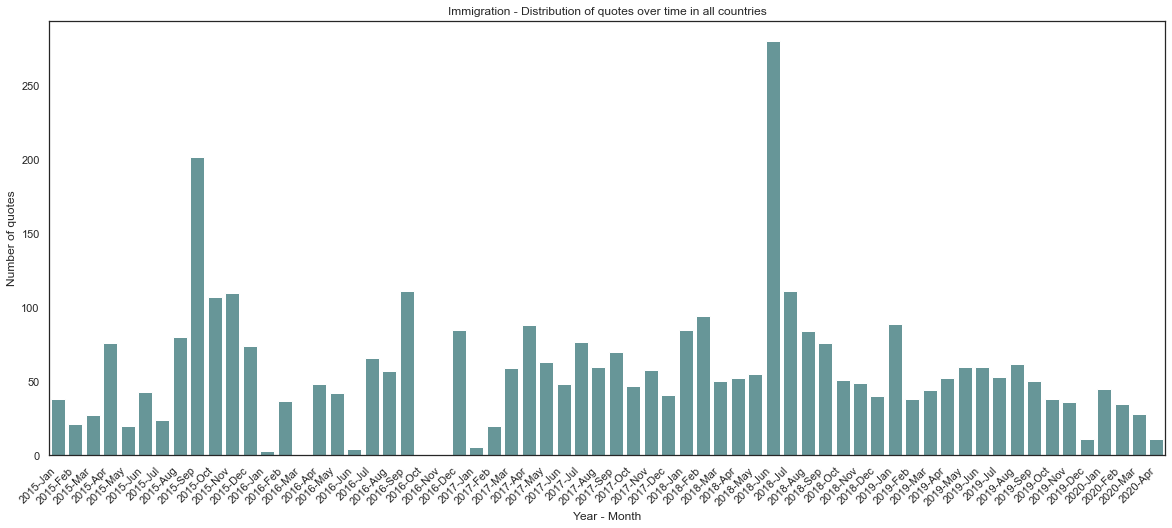

In [85]:
topic_name = 'Immigration'
df = immigration_quotes
show_time_distribution(topic_name, df)


### Distribution over time per country

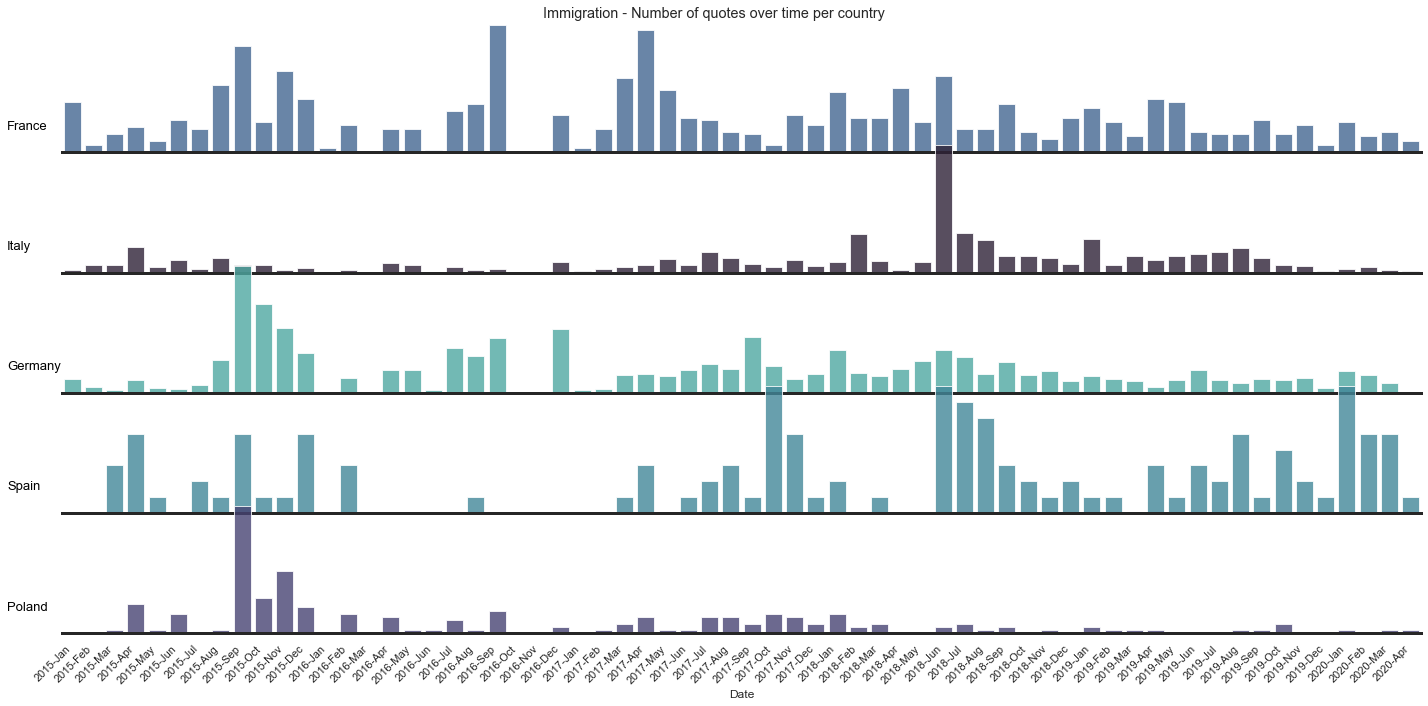

In [86]:
show_time_distribution_per_country(topic_name, df)

### Distribution over political alignments

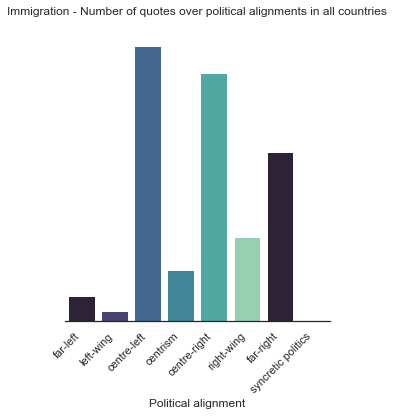

In [87]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

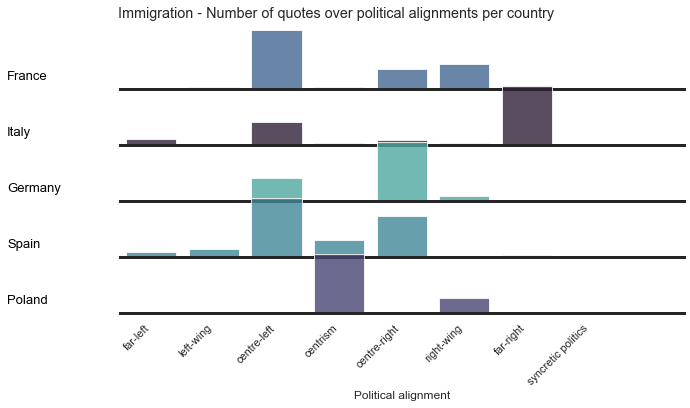

In [88]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

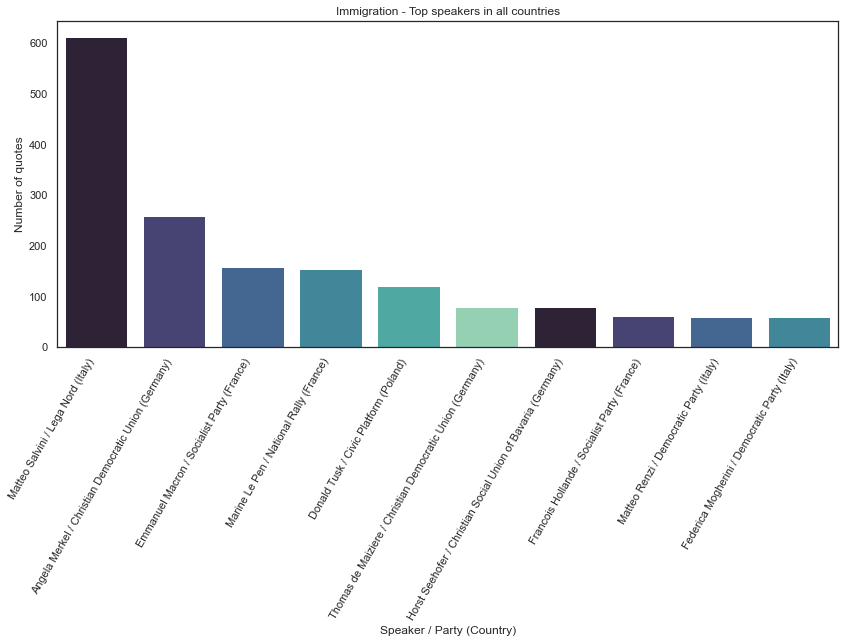

In [89]:
show_top_k_speakers(topic_name, df)

### Explanation

In the first figure, one can see a huge peak in June 2018. Another important peak happened in September 2015.
We will explain these peaks in the following part.

On the other hand, the number of quotes was really limited during many cold months.
This can be explained by saying that it is more likely for migrants to travel during favourable months with good weather.

#### <center>September 2015</center>
<center><img src="https://www.unhcr.org/thumb1/56eab9aaa.jpg" width=600></center>

During this year, the main route shifted from the dangerous Mediterranean crossing from Libya to Italy, to what would prove to be an even deadlier crossing from Turkey to Greek islands like Lesvos.
This explains why the peak is completely absent in Italy's point of view and, in the other hand, is quite marked in Germany or Poland.
Over 75 per cent of those arriving in Europe had fled conflict and persecution in Syria, Afghanistan or Iraq.

The peak on this month can be sadly explained by a drammatic event that took place on 2 September 2015.
On this day, <a href='https://en.wikipedia.org/wiki/Death_of_Alan_Kurdi'>Alan Kurdi</a>, a three-years-old Syrian boy, lost his life trying to reach Europe from Turkey.
The photo of his body laying on a beach in Turkey moved millions worldwide.

By the time Aylan's body washed ashore, more than 300,000 people had risked their lives to reach Europe. Over 2,600 had perished in the attempt.

#### <center>June 2018 and Matteo Salvini</center>
<center><img src="https://ichef.bbci.co.uk/news/976/cpsprodpb/0260/production/_102080600_migrant_ship_with_spain_640_v4-nc.png
" width=600></center>

At first glance, this peak is clearly caused by Italy and, most likely, by the most popular speaker in the immigration topic, Matteo Salvini. However, this huge crest could be quite weird by just looking at <a href='https://www.youtrend.it/2021/02/15/sbarchi-e-immigrazione-in-italia-il-punto-della-situazione/'>data.</a> The number of migrants in 2018 is quite low if compared to the figures of the previous years.

However, something happened in Italian politics during these days. Indeed, <a href='https://en.wikipedia.org/wiki/Matteo_Salvini'>Matteo Salvini</a>, leader of the far-right party "Lega Nord", was sworn in as Deputy Prime Minister and Minister of the Interior on 1 June 2018. He immediately stated that his main aim was to drastically reduce the number of illegal immigrants to Italy.

On 10 June 2018, Salvini announced the closure of Italian ports. The vessel <b>Aquarius</b>, which carried more than 600 migrants, was refused a port of disembarkation by the Italian authorities. It was accepted by Spanish authorities, and it finally arrived at the Port of Valencia on 17 June 2018.


References:
- Wikipedia
- https://www.unhcr.org/news/stories/2015/12/56ec1ebde/2015-year-europes-refugee-crisis.html
- https://www.bbc.com/news/world-44510002

# European Union and Brexit

### Distribution over time in all countries

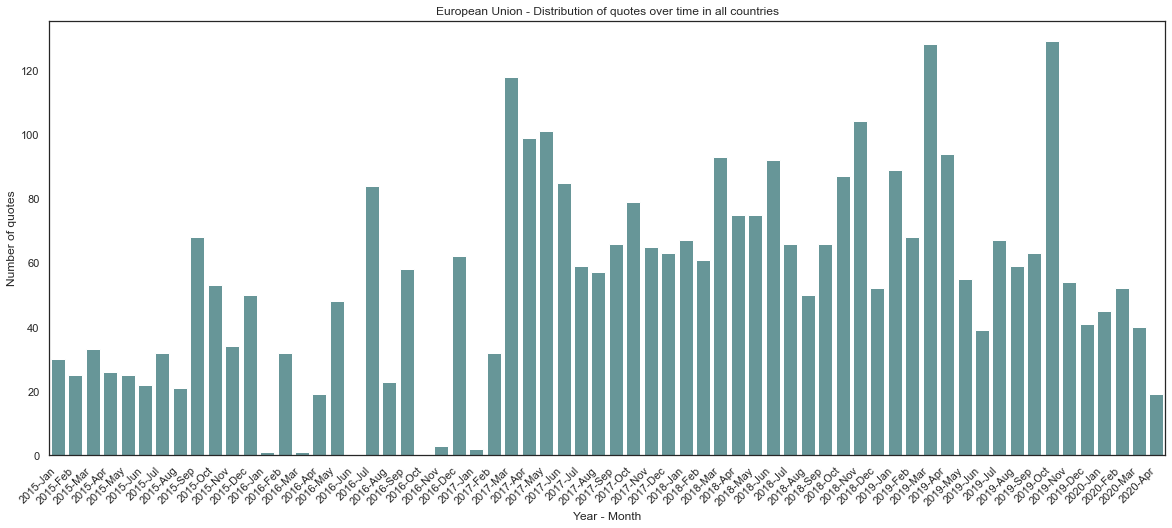

In [90]:
topic_name = 'European Union'
df = europe_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

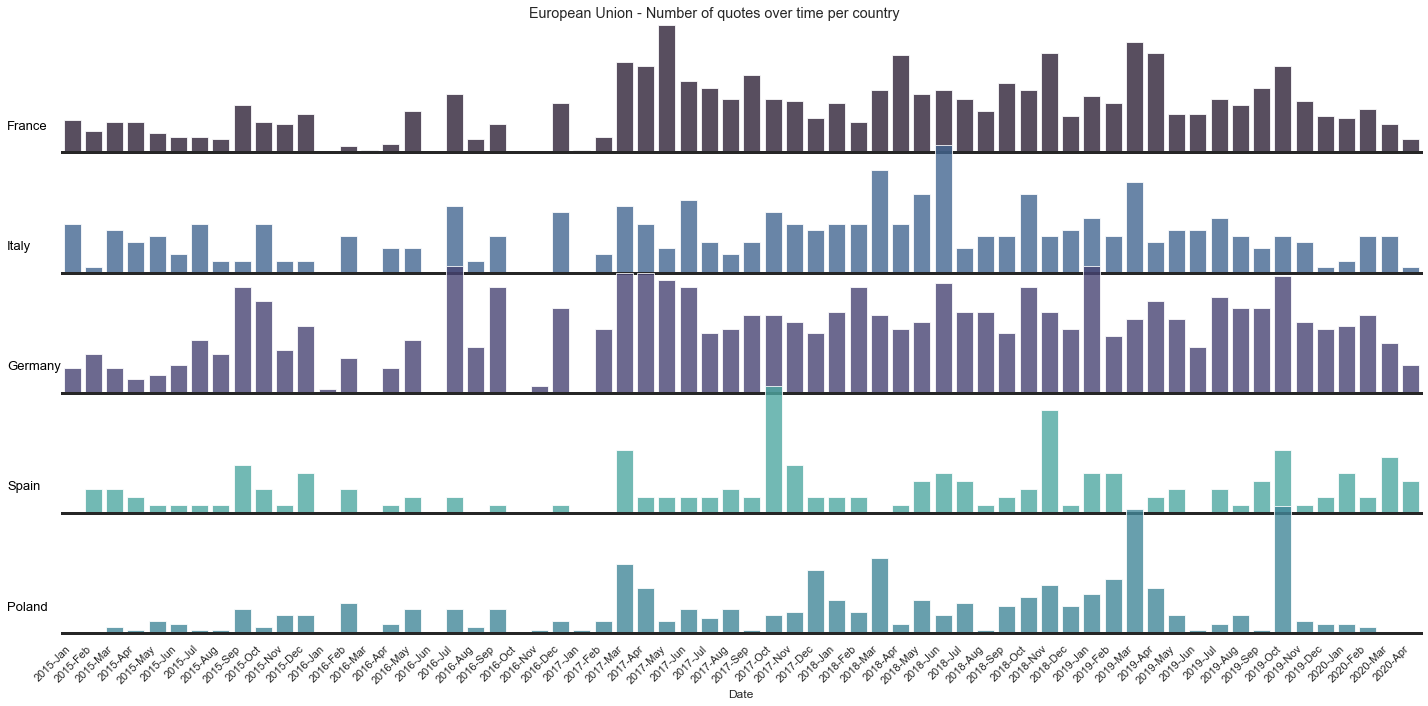

In [91]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

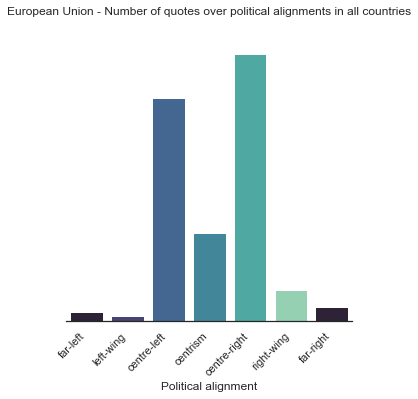

In [92]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

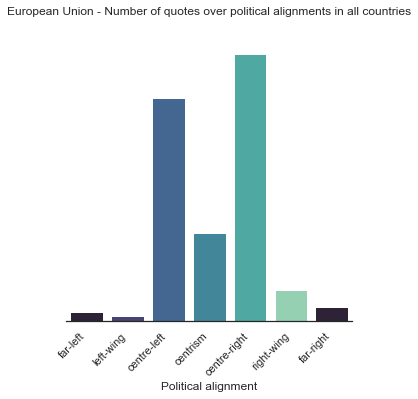

In [93]:
show_political_orientation_distribution(topic_name, df)

### Top speakers in all countries

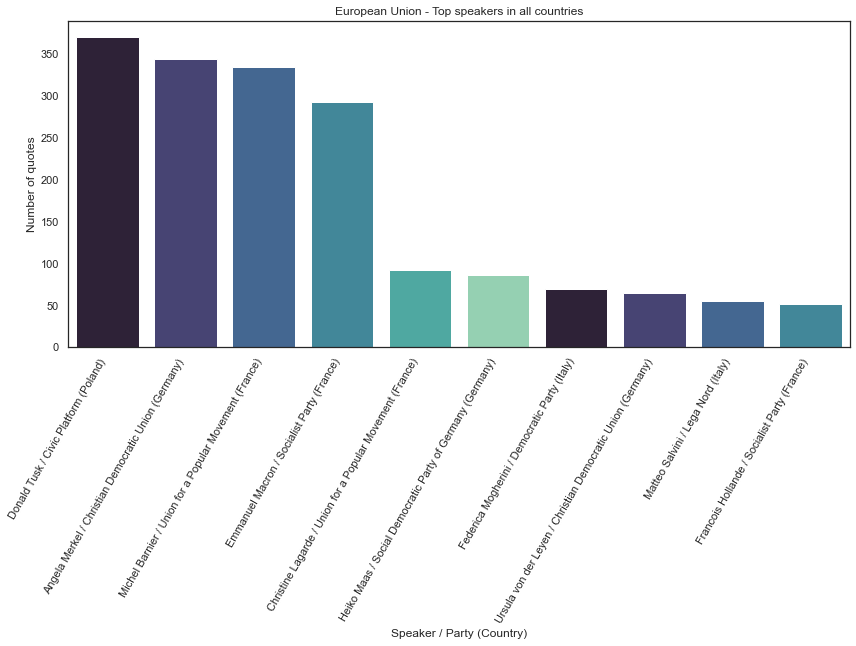

In [94]:
show_top_k_speakers(topic_name, df)

### Explanation

This time we will start our analysis from the most popular speakers.
We can see, indeed, that there are eminent European politicians:
- Donald Tusk (President of the European Council from 2014 to 2019)
- Michel Barnier (Former European Commissioner for Cohesion and Reforms)
- Christine Lagarde (President of the European Central Bank)
- Federica Mogherini (Former High Representative of the European Union for Foreign Affairs and Security Policy).
- Ursula von der Leyen (President of the European Commission)

As we will see, the peaks correspond to important events of Brexit, the withdrawal of the United Kingdom from the European Union.

#### <center>March 2017</center>
<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Prime_Minister%E2%80%99s_letter_to_Donald_Tusk_triggering_Article_50.pdf/page1-390px-Prime_Minister%E2%80%99s_letter_to_Donald_Tusk_triggering_Article_50.pdf.jpg' width=300></center>

On 29 March 2017, the United Kingdom invoked Article 50 of the Treaty on European Union which began the member state's withdrawal from the European Union.

In compliance with the TEU, the UK gave formal notice to the European Council of its intention to withdraw from the EU to allow withdrawal negotiations to begin.

#### <center>March 2019</center>

The UK had long been expected to leave the European Union at 11pm on 29 March 2019.  However, following a House of Commons vote on 14 March 2019, the Government sought permission from the EU to extend Article 50 and agree a later Brexit date.

On 20 March 2019 the Prime Minister, Theresa May, wrote to European Council President Donald Tusk, asking to extend Article 50 until 30 June 2019.

#### <center>October 2019</center>
In the run-up to the scheduled date for the UK’s departure at Halloween, Boris Johnson’s government finally sealed a new exit deal with the EU – but a missed deadline in the British parliament forced the prime minister by law to seek another Brexit delay.

European leaders agreed to the request for a three-month extension, while UK lawmakers finally agreed to an early general election in December to try to clear the path ahead.


References:
- <a href='https://en.wikipedia.org/wiki/United_Kingdom_invocation_of_Article_50_of_the_Treaty_on_European_Union'>United Kingdom invocation of Article 50 of the Treaty on European Union</a>
- <a href='https://commonslibrary.parliament.uk/research-briefings/cbp-7960/'>Brexit timeline: events leading to the UK’s exit from the European Union</a>
- <a href='https://www.euronews.com/2019/10/31/from-deal-to-delay-what-happened-with-brexit-in-october'>From deal to delay: what happened with Brexit in October?</a>

# Discriminations

### Distribution over time in all countries

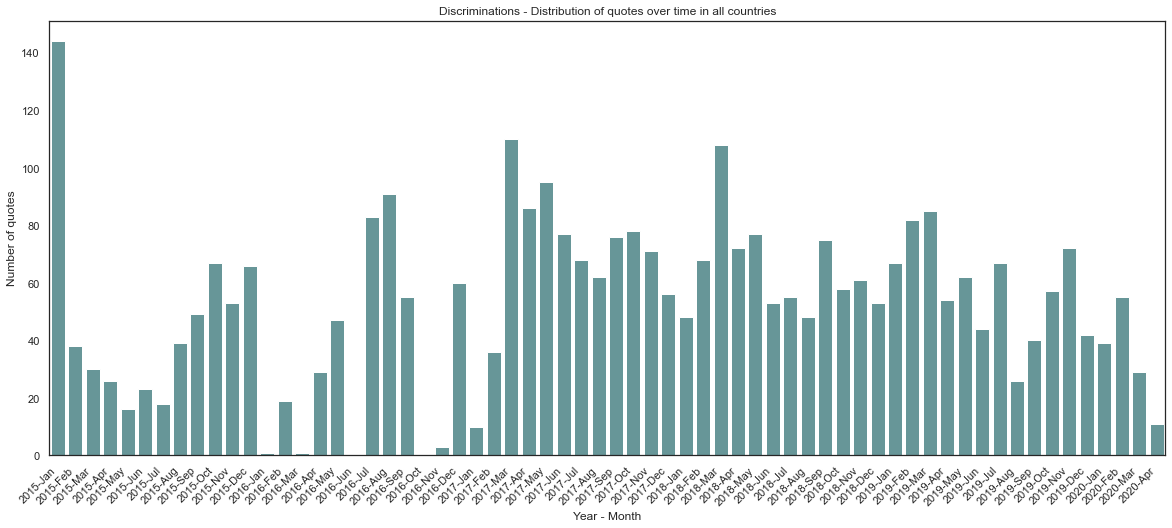

In [95]:
topic_name = 'Discriminations'
df = discrimination_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

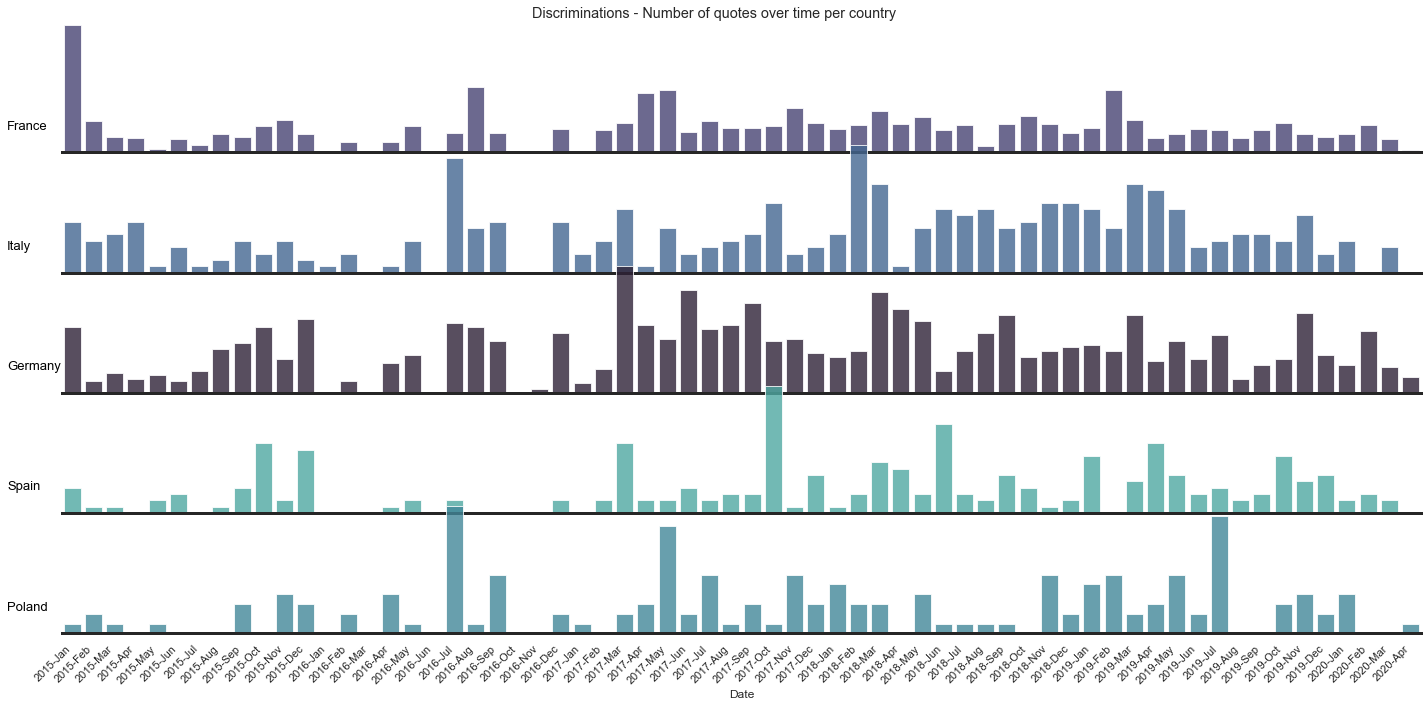

In [96]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

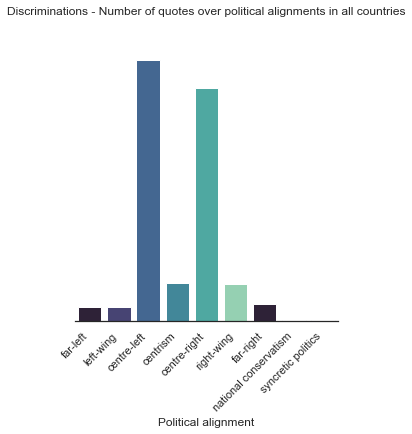

In [97]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

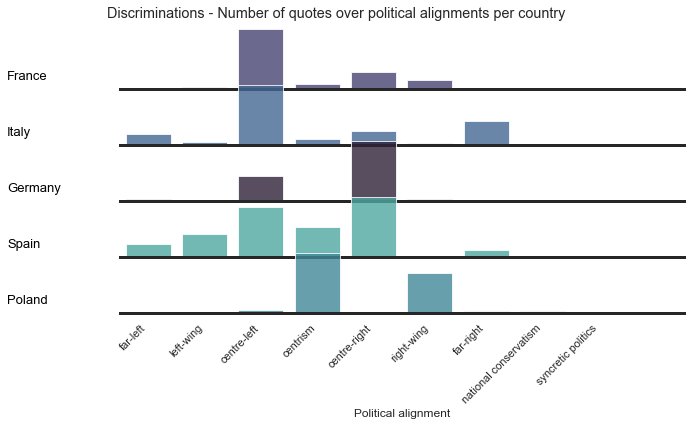

In [98]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

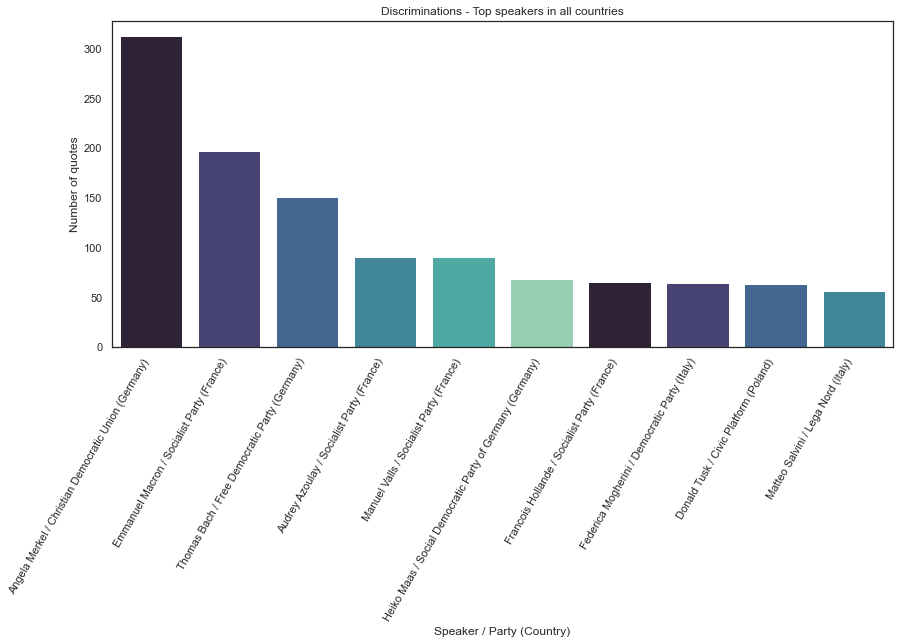

In [99]:
show_top_k_speakers(topic_name, df)

### Explanation
First, we can observe a huge peak in January 2015, corresponding to the only peak in France.
In addition, there are a few more peaks but we will focus on the peaks from the countries distributions.

#### <center>January 2015</center>
The most important peak is linked to the Islamic terrorism attacks of the same month in France.

It is also an important event for discriminations. The former President of France, Hollande, affirmed that radical Islam had fed off contradictions, poverty, inequality and conflict, and that "it is Muslims who are the first victims of fanaticism, fundamentalism and intolerance".

He also added that "French Muslims have the same rights as all other French [...]. We have the obligation to protect them. [...] Anti-Muslim and anti-Semitic acts have to be condemned and punished."

#### <center>July 2016</center>
As in the last case, the peak is mainly because of Donald Tusk's statements on Nice terrorism attack. In fact, he affirmed that the "subjects of the attack were people celebrating liberty, equality and fraternity".

#### <center>March 2017</center>
This peak can be linked to the third top speaker: <a href='https://en.wikipedia.org/wiki/Thomas_Bach'>Thomas Bach</a>, President of the International Olympic Committee.
In fact, the International Olympic Committee (IOC) Executive Board on this day approved a major review project regarding gender equality in the Olympic Movement.

#### <center>October 2017</center>
This time the main term is "liberty". In fact, in October 2017, the Catalan independence referendum took place.


References:
- <a href='https://www.bbc.com/news/world-europe-30829733'>France to protect all religions, vows Francois Hollande</a>
- <a href='https://olympics.com/ioc/news/ioc-launches-bold-initiative-on-gender-equality'>IOC launches bold initiative on gender equality</a>

# Drugs

### Distribution over time in all countries

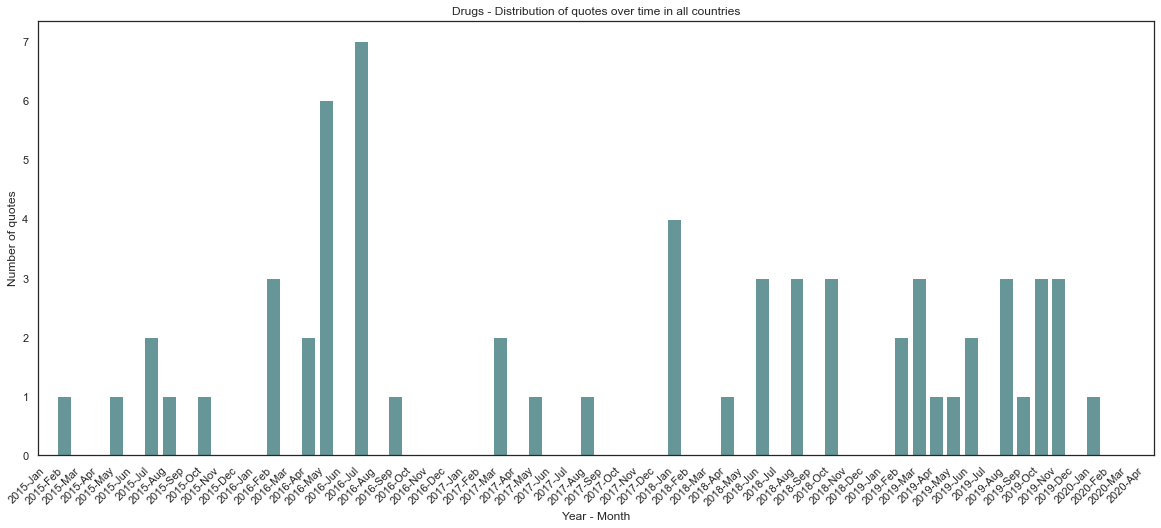

In [144]:
topic_name = 'Drugs'
df = drugs_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

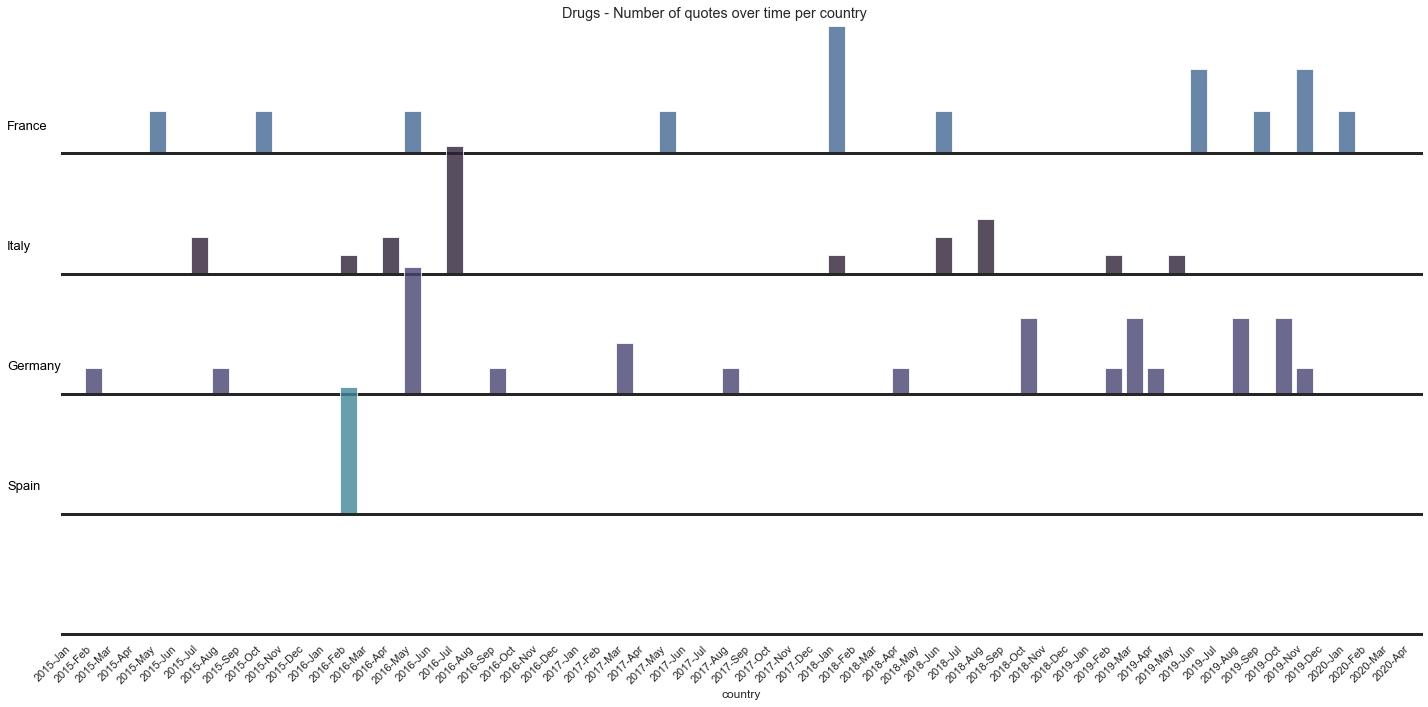

In [145]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

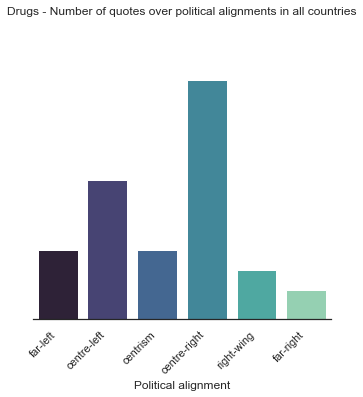

In [146]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

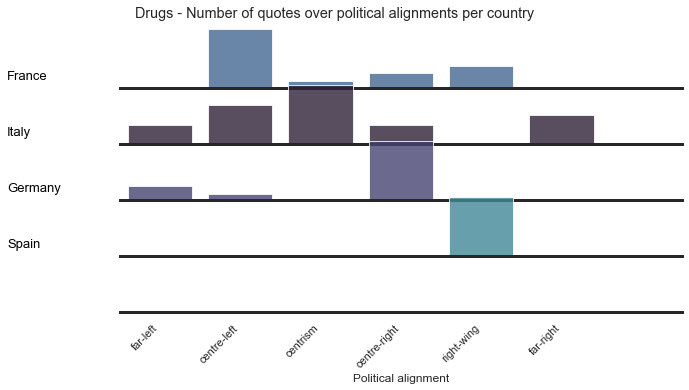

In [147]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

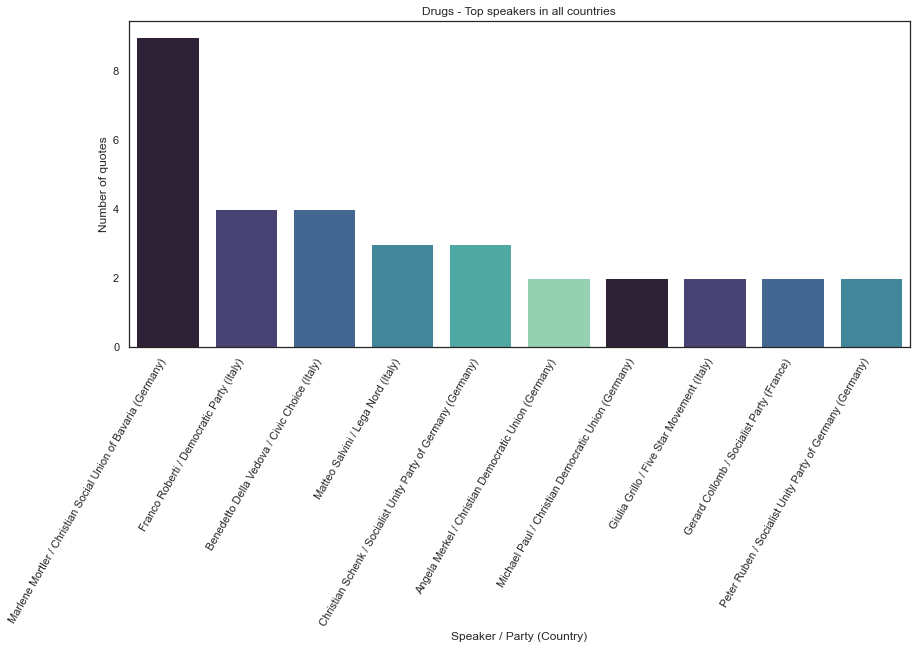

In [148]:
show_top_k_speakers(topic_name, df)


# Climate change

### Distribution over time in all countries

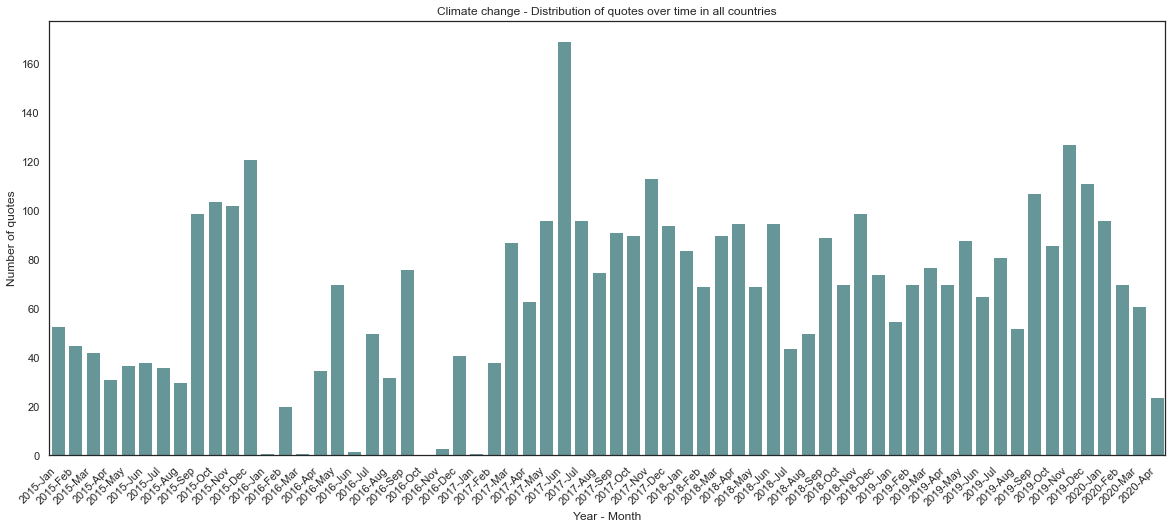

In [105]:
topic_name = 'Climate change'
df = climate_change_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

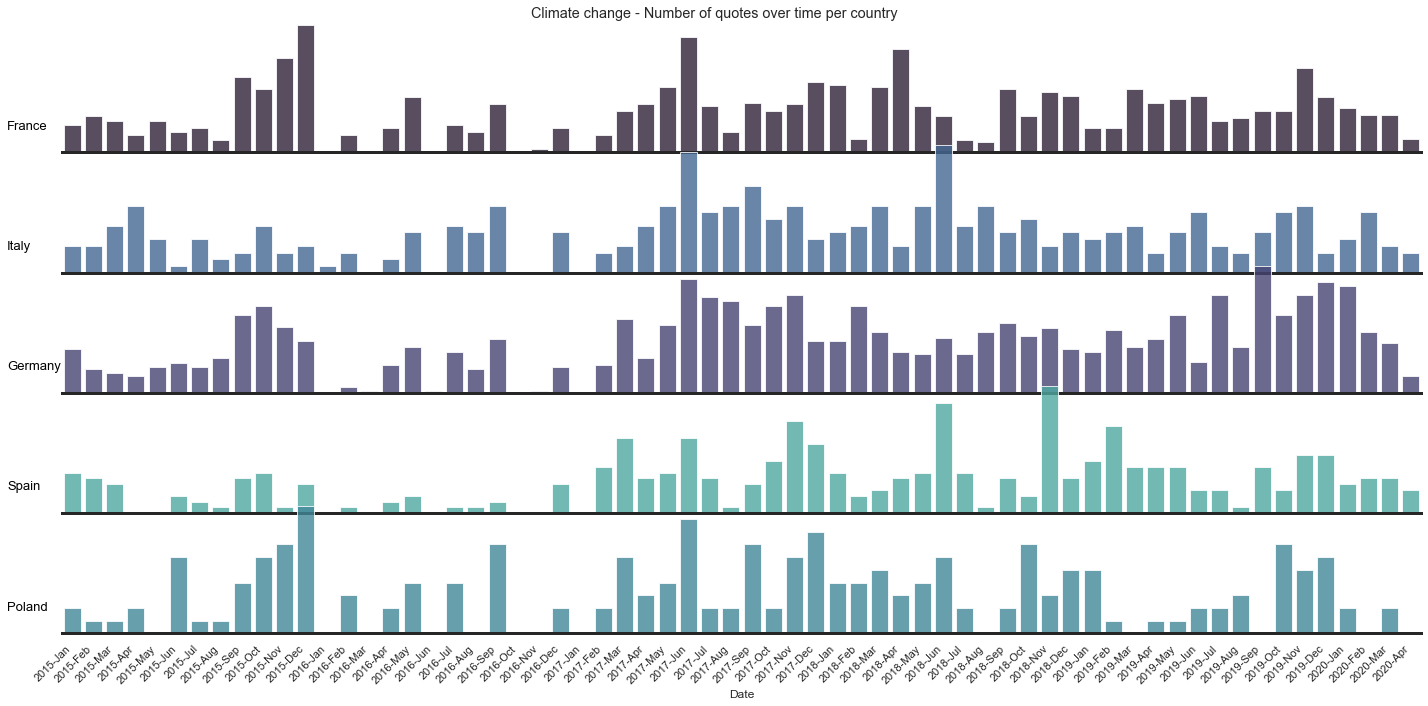

In [106]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

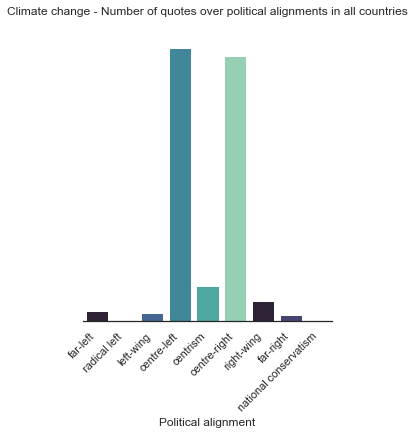

In [107]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

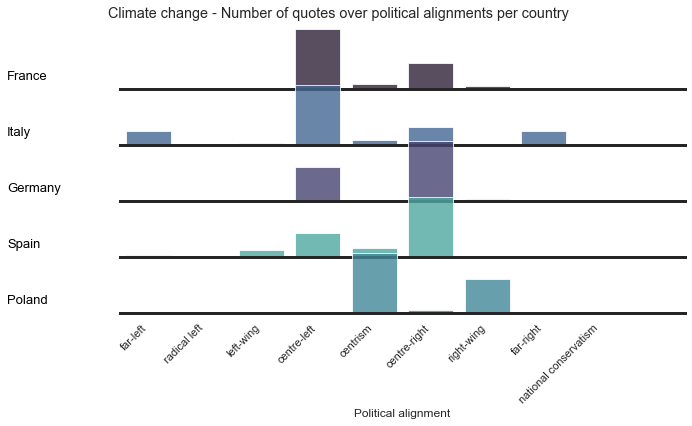

In [108]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

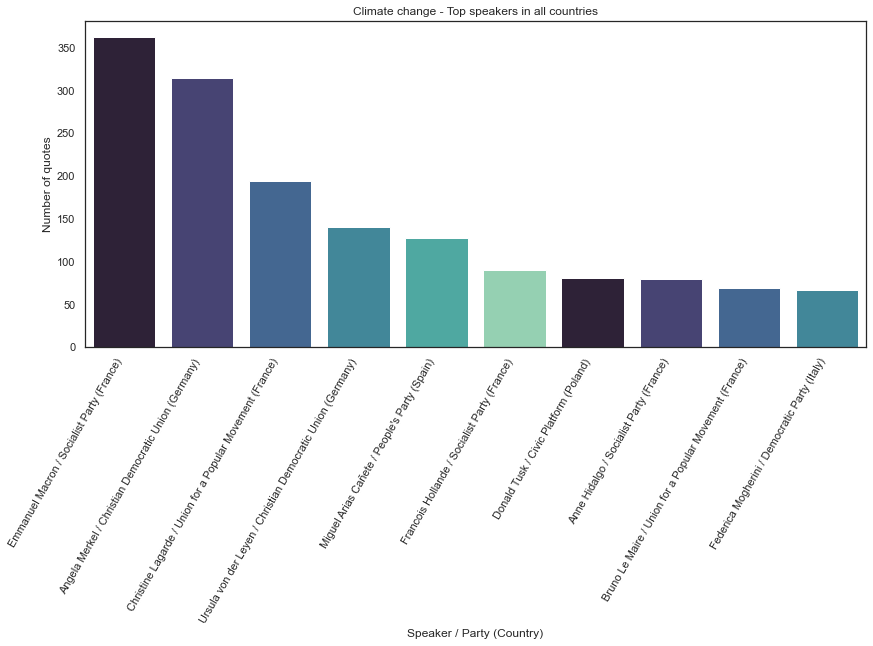

In [109]:
show_top_k_speakers(topic_name, df)

### Explanation

We can see that this time the distribution in all the countries look alike.

In addition, there is only one important peak, in June 2017. In particular, on June 1, 2017, United States President Donald Trump announced that the U.S. would cease all participation in the 2015 Paris Agreement on climate change mitigation, contending that the agreement would "undermine" the U.S. economy, and put the U.S. "at a permanent disadvantage."

Reference:
- <a href='United States withdrawal from the Paris Agreement'>https://en.wikipedia.org/wiki/United_States_withdrawal_from_the_Paris_Agreement</a>

# Russia

### Distribution over time in all countries

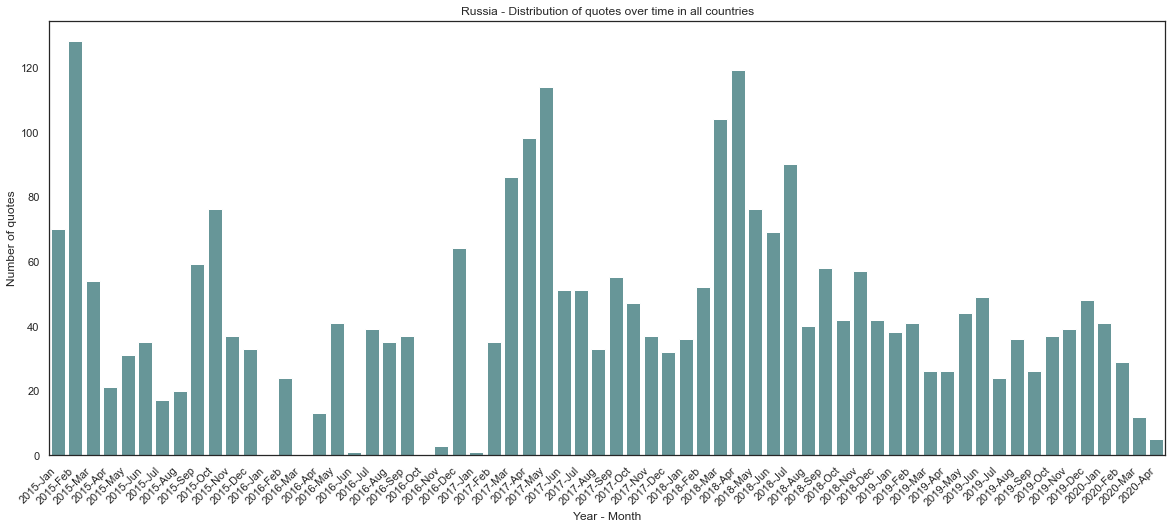

In [110]:
topic_name = 'Russia'
df = russia_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

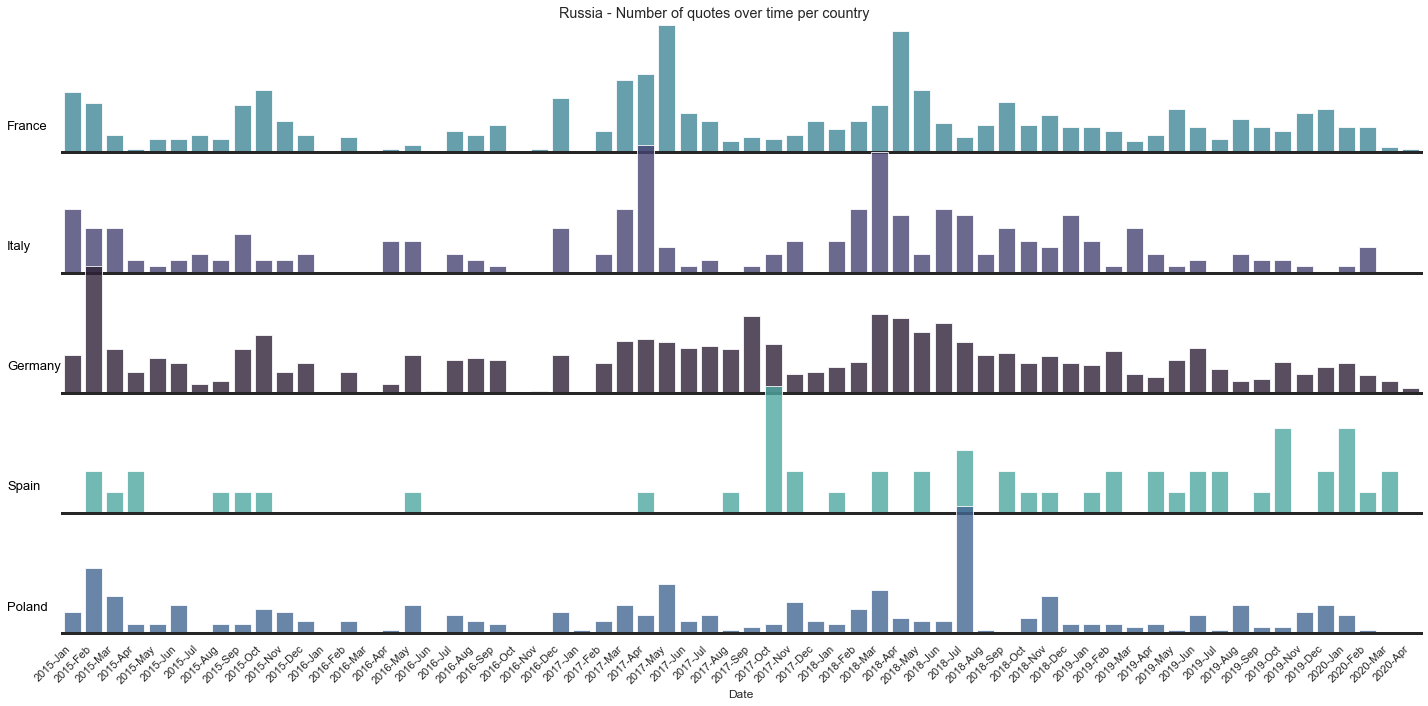

In [111]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

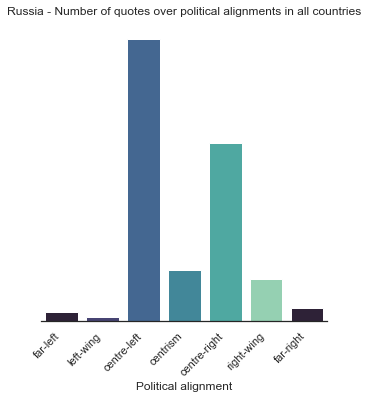

In [112]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

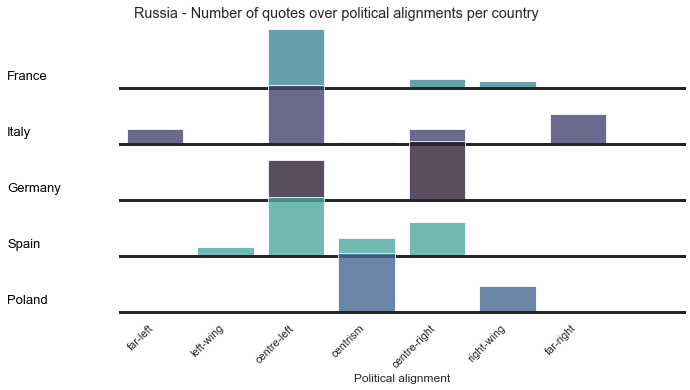

In [113]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

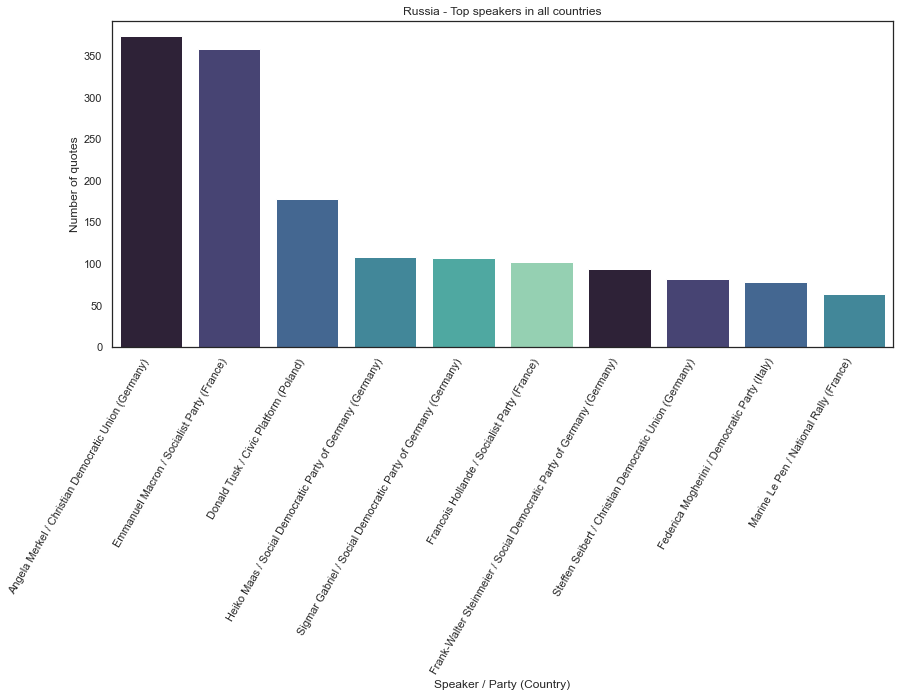

In [114]:
show_top_k_speakers(topic_name, df)

### Explanation
We can see that France and Italy gave the same attention to this topic and, also, similarly to Germany.
On the other hand, the topic was almost not touched by Spain and Poland, except for two months.

The main peak was reached on February 2015. During this month, a dangerous escalation between Russia and Ukraine happened.
However, the situation improved when on 12 February 2015 the leaders of Russia, Ukraine, France and Germany have reached a ceasefire deal after 17 hours of talks in Minsk, Belarus, on the Ukrainian conflict.


Reference:
- <a href='https://www.theguardian.com/world/2015/feb/12/ukraine-crisis-reports-emerge-of-agreement-in-minsk-talks'>https://www.theguardian.com/world/2015/feb/12/ukraine-crisis-reports-emerge-of-agreement-in-minsk-talks</a>

# Coronavirus

### Distribution over time in all countries

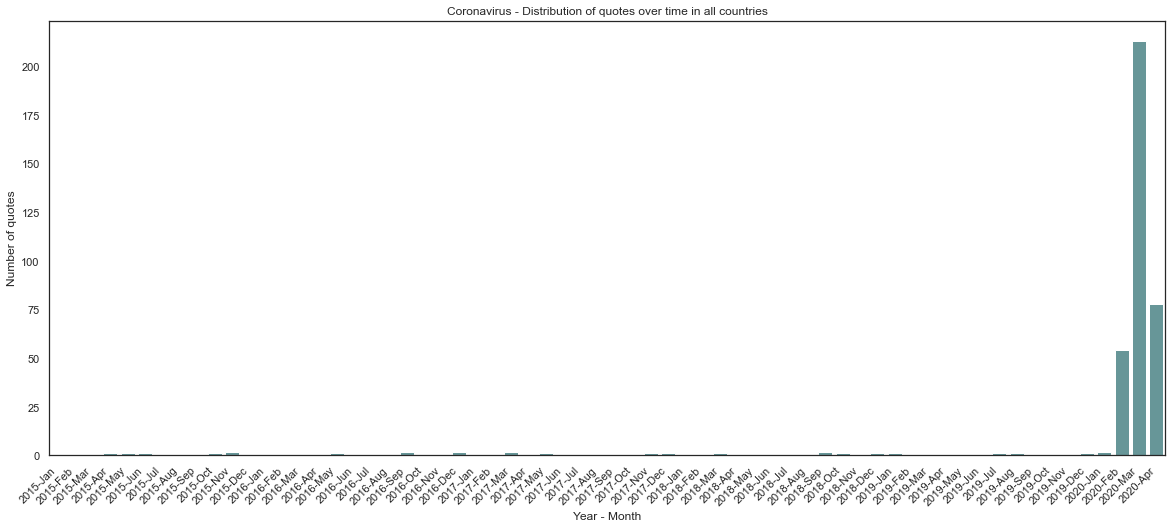

In [115]:
topic_name = 'Coronavirus'
df = covid_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

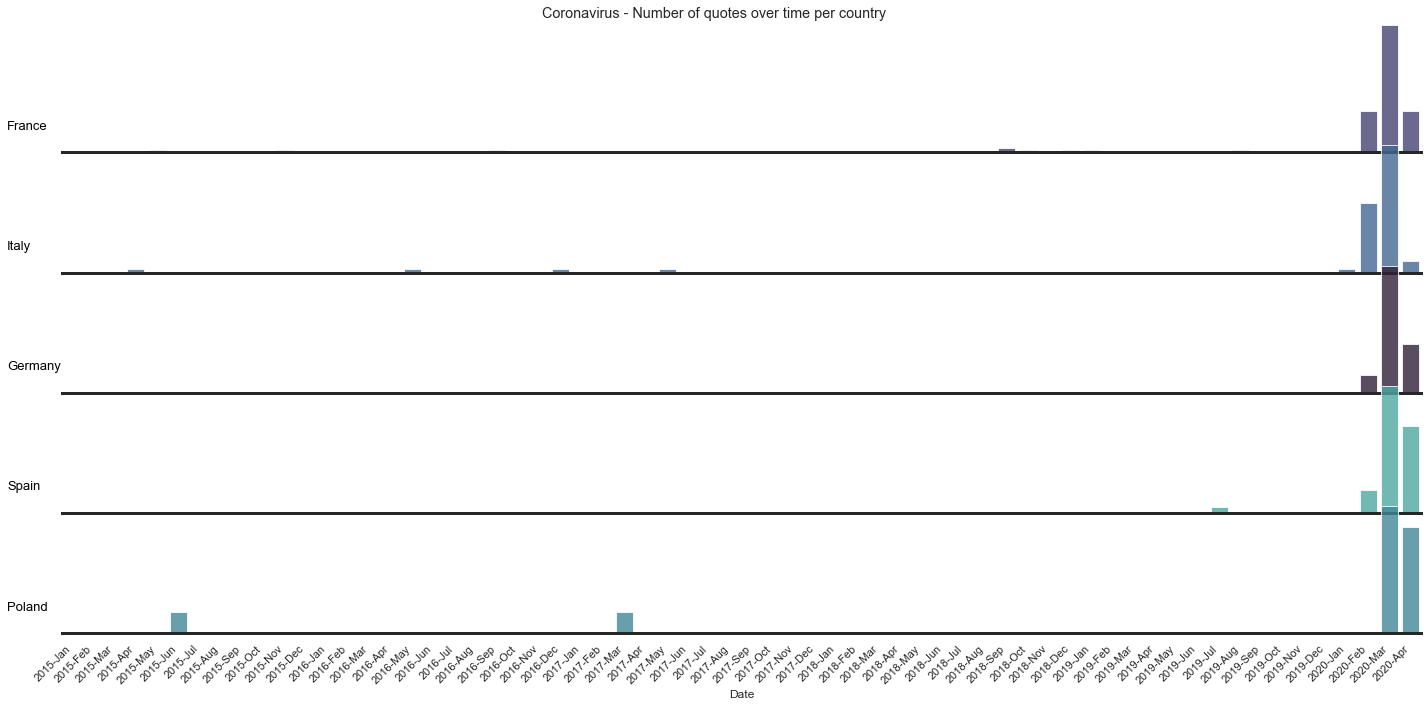

In [116]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

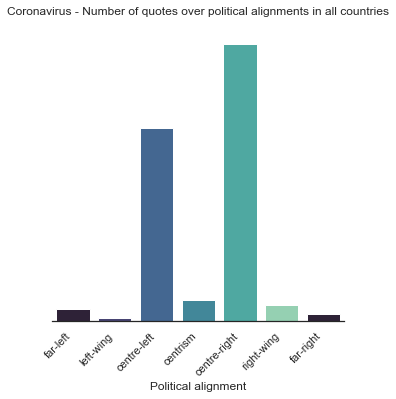

In [117]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

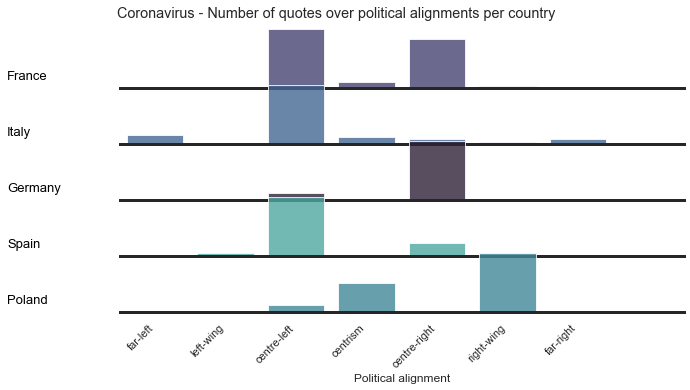

In [118]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

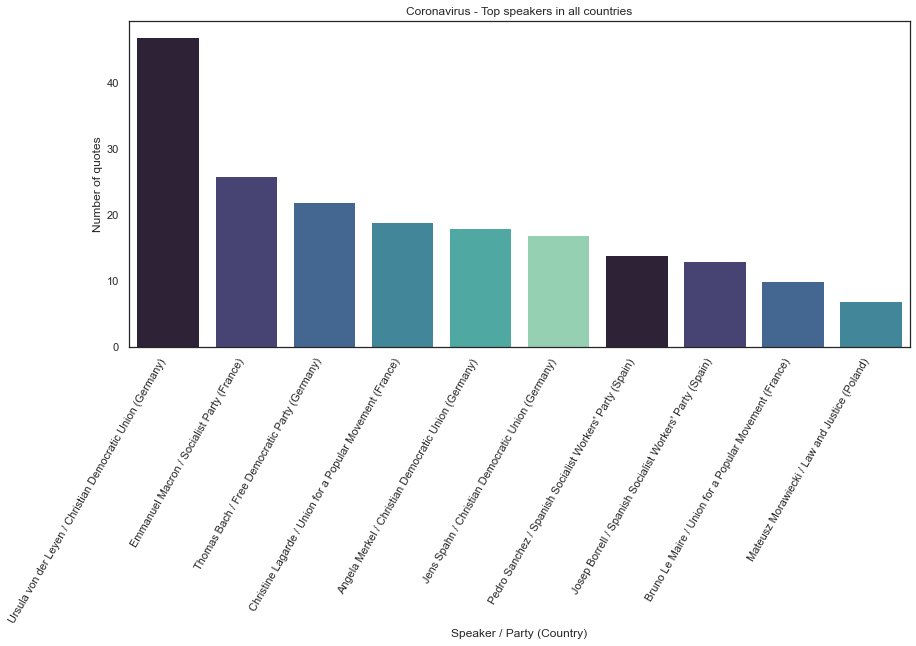

In [119]:
show_top_k_speakers(topic_name, df)


### Explanation

The Quotebank dataset covered only the first months for this important thematic. Therefore, no big difference can be noticed between the countries.

However, one can see that in Italy the weight of the distribution in February 2020 was much higher than in the other countries.

The explanation is very simple: Italy was the first European country to be severely hit by Covid-19 and the first to impose strict rules to fight the contagion.

Reference:
- <a href='https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Italy'>COVID-19 pandemic in Italy</a>

# Terrorism

### Distribution over time in all countries

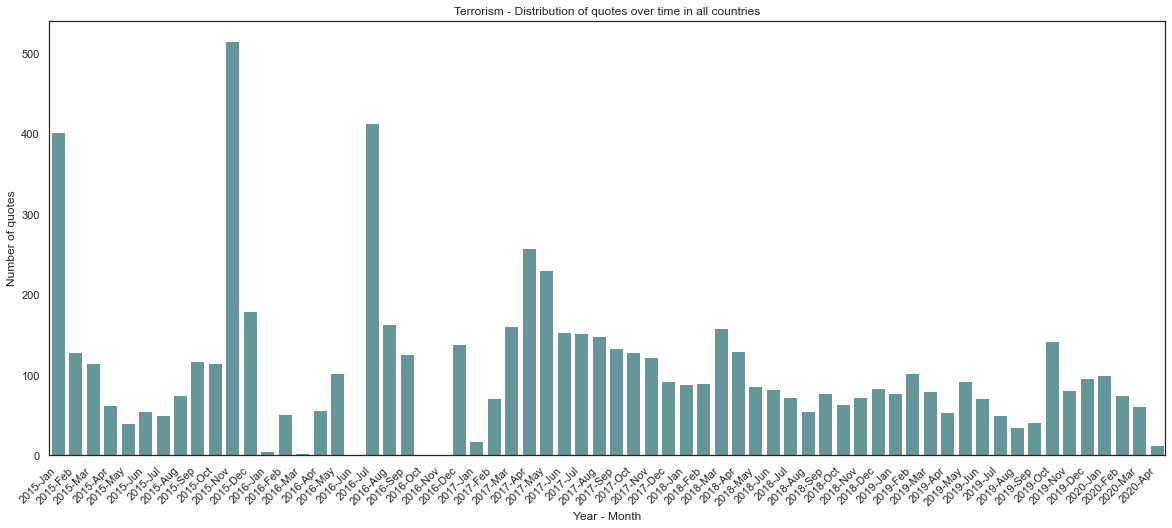

In [127]:
topic_name = 'Terrorism'
df = terrorism_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

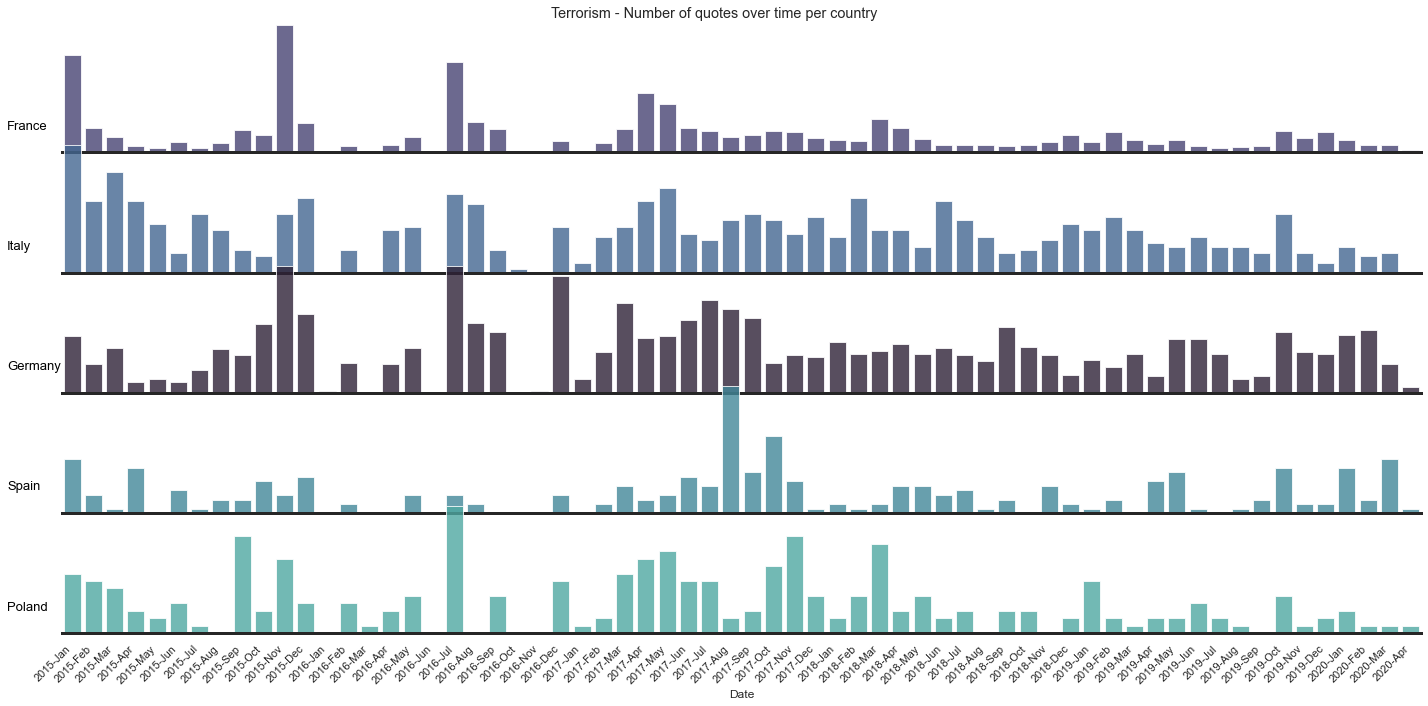

In [128]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

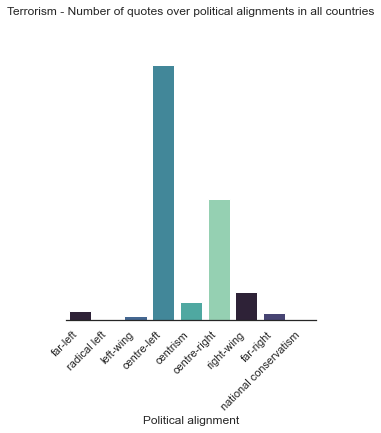

In [129]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

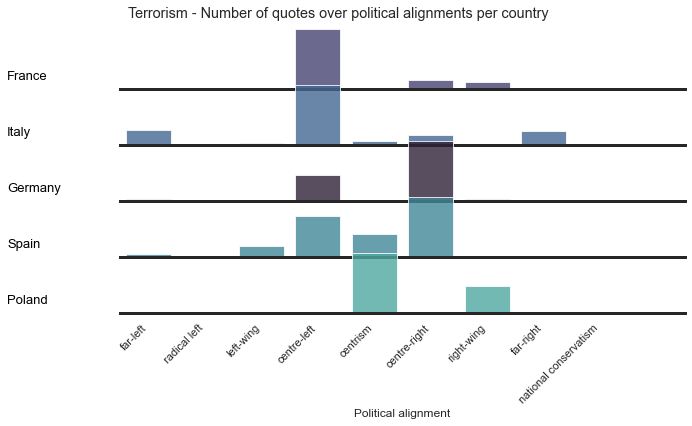

In [130]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

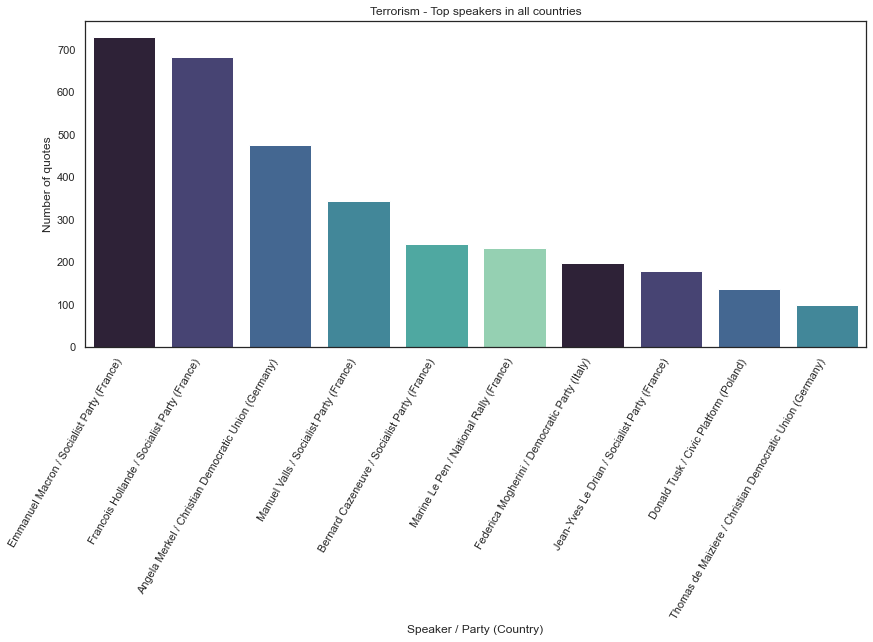

In [131]:
show_top_k_speakers(topic_name, df)

### Explanation

The first tragic aspect to note in this topic is that the most quoted speakers are French.
This is clearly related to the particular gravity of the terrorism problem in France.

In addition, we can notice that Italy has no big peaks as it has never been targeted by attacks. The same could be said about Poland, but Donald Tusk, who is polish, happened to be the President of the European Council during these events.

On the other hand, Spain has a peak (August 2017) that it is not shared with the other countries. This is also the case for Germany, in December 2016.

Therefore, we will analyse the three biggest peaks, January 2015, November 2015 and July 2016, as well as the Spanish and German ones.

#### <center>January 2015</center>
<center><img src='https://upload.wikimedia.org/wikipedia/commons/b/b2/Je_suis_Charlie%2C_Paris_11_January_2015_%283%29.jpg' width=600></center>

From 7 to 9 January 2015, terrorist attacks occurred across the Île-de-France region, particularly in Paris. Three attackers killed a total of 17 in four shooting attacks, and police then killed the three assailants.

The most renowned is the first one: on 7 January, two gunmen attacked the headquarters of the satirical newspaper Charlie Hebdo, killing 12 people and wounding 12 others before escaping.

#### <center>November 2015</center>
<center><img src='https://api.time.com/wp-content/uploads/2020/11/GettyImages-873714544.jpg?w=800&quality=85' width=600></center>

On 13 November 2015, a series of coordinated Islamist terrorist attacks took place in Paris:
- Three suicide bombers struck outside the Stade de France in Saint-Denis, during an international football match, after failing to gain entry to the stadium.
- Another group of attackers then fired on crowded cafés and restaurants in Paris, with one of them also blowing himself up.
- A third group carried out another mass shooting and took hostages at a rock concert attended by 1,500 people in the Bataclan theatre.

The attackers killed 130 people, including 90 at the Bataclan theatre.Another 416 people were injured, almost 100 critically.

#### <center>July 2016</center>
<center><img src='https://static01.nyt.com/images/2016/07/19/world/video-nice/video-nice-superJumbo.jpg' width=600></center>

On the evening of 14 July 2016, a 19-tonne cargo truck was deliberately driven into crowds of people celebrating Bastille Day on the Promenade des Anglais in Nice, France, resulting in the deaths of 86 people and the injury of 458 others.

#### <center>December 2016</center>
<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Terroranschlag-Berlin-Breitscheidplatz-2016_%282%29_%2831731061626%29_%28square_crop%29.jpg/1280px-Terroranschlag-Berlin-Breitscheidplatz-2016_%282%29_%2831731061626%29_%28square_crop%29.jpg' width=400></center>

On 19 December 2016, an unsuccessful asylum seeker from Tunisia drove a stolen truck through a Christmas market at Breitscheidplatz in the City West of Berlin, killing 11 people and injuring 56.

The incident is the deadliest terrorist attack in Germany since an attack at Oktoberfest in Munich in 1980.

#### <center>August 2017</center>
<center><img src='https://static01.nyt.com/images/2016/07/19/world/video-nice/video-nice-superJumbo.jpg' width=600></center>

On the afternoon of 17 August 2017, 22-year-old Younes Abouyaaqoub drove a van into pedestrians on La Rambla in Barcelona, Catalonia, Spain killing 13 people and injuring at least 130 others, one of whom died 10 days later on 27 August. Abouyaaqoub fled the attack on foot, then killed another person in order to steal the victim's car to make his escape.

Nine hours after the Barcelona attack, five men thought to be members of the same terrorist cell drove into pedestrians in nearby Cambrils, killing one woman and injuring six others.


References:
- <a href='https://en.wikipedia.org/wiki/January_2015_%C3%8Ele-de-France_attacks'>January 2015 Île-de-France attacks</a>
- <a href='https://en.wikipedia.org/wiki/November_2015_Paris_attacks'>November 2015 Paris attacks</a>
- <a href='https://en.wikipedia.org/wiki/2016_Nice_truck_attack'>2016 Nice truck attack</a>
- <a href='https://en.wikipedia.org/wiki/2016_Berlin_truck_attack'>2016 Berlin truck attack</a>
- <a href='https://en.wikipedia.org/wiki/2017_Barcelona_attacks'>2017 Barcelona attacks</a>

# Most popular topics per country

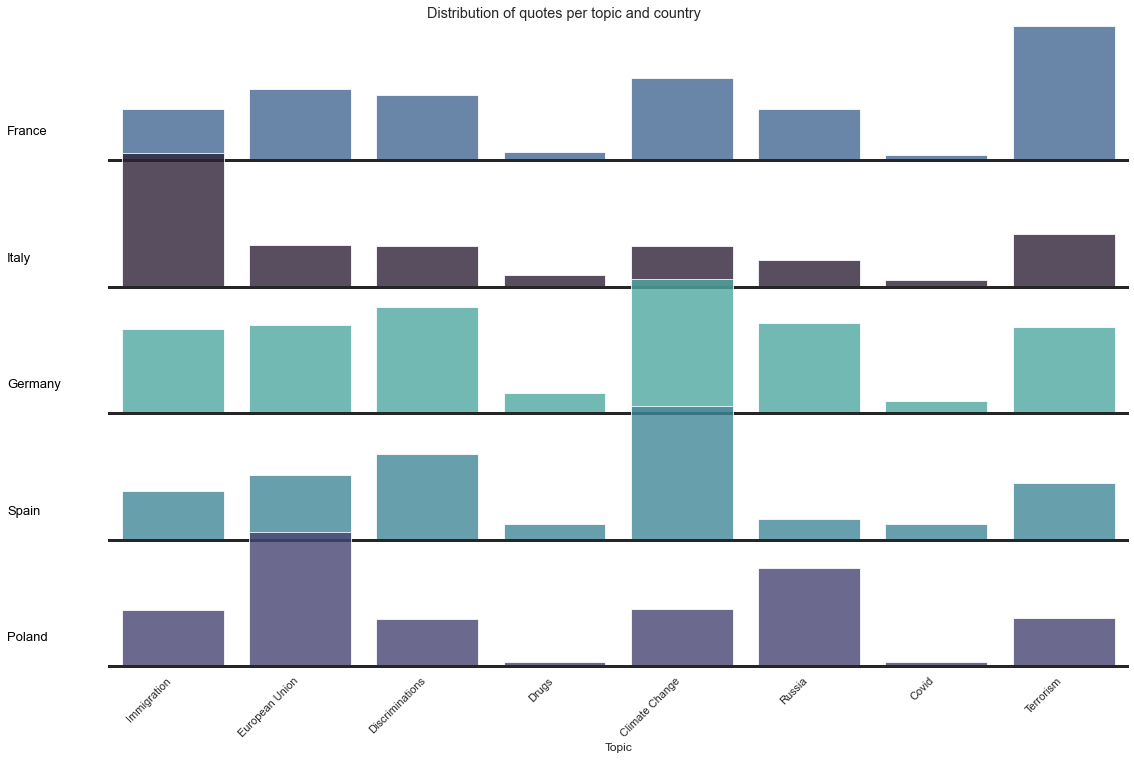

In [125]:
show_top_topics_per_country([immigration_quotes, europe_quotes, discrimination_quotes, drugs_quotes, climate_change_quotes, russia_quotes, covid_quotes, terrorism_quotes],
                            ["Immigration", "European Union", "Discriminations", "Drugs", "Climate change", "Russia", "Covid", "Terrorism"])

All the previous explanations naturally suggest what we can see from this image:

- the most important topic in France is terrorism, as the country was the target of many attacks.
- in Italy, immigration is the most popular topic. This is because of the European migrant crisis and of the favourable geographical position of Italy.
- Germany, as well as Spain, do not have remarkably more popular topics. Indeed, for example, both countries faced the problems of immigration and were target of terrorists.<br>One difference could be that, in Spain, the Russia topic was much less important than in Germany, probably because of the key roles of German politicians in the relation between EU and Russia.
- in Poland, the European Union / Brexit topic was the most important one. This could be explained by the key importance of the Polish politician Donald Tusk in this topic because of his role.
